In [13]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/inventory_optimization_data_.csv")

df.head()


,sku_id,category,record_date,avg_daily_demand,lead_time_days,unit_cost,holding_cost_pct,stockout_cost,current_inventory,supplier_rating
0,SKU_00001,FMCG,21-05-2025,10,30,3929.90,0.23,6370.63,291,3.7
1,SKU_00001,FMCG,08-06-2025,19,29,3597.80,0.34,8636.88,395,2.9
2,SKU_00001,Apparel,18-06-2025,5,27,899.55,0.12,1506.24,180,2.7
3,SKU_00001,FMCG,19-06-2025,22,30,1205.88,0.25,4275.87,963,3.4
4,SKU_00001,Automotive,03-08-2025,23,11,1523.48,0.31,3387.98,203,3.5


In [14]:
# Create lead time demand
df["lead_time_demand"] = df["avg_daily_demand"] * df["lead_time_days"]

# Safety stock
df["safety_stock"] = 1.65 * (df["avg_daily_demand"] * 0.3) * np.sqrt(df["lead_time_days"])

# Reorder point
df["reorder_point"] = df["lead_time_demand"] + df["safety_stock"]

# Shortage quantity
df["shortage_qty"] = np.maximum(df["reorder_point"] - df["current_inventory"], 0)

# Target variable
df["stockout_flag"] = np.where(
    df["current_inventory"] < df["reorder_point"], 1, 0
)


In [15]:
features = [
    "avg_daily_demand",
    "lead_time_days",
    "current_inventory",
    "stockout_cost",
    "holding_cost_pct",
    "supplier_rating",
    "shortage_qty"
]

X = df[features]
y = df["stockout_flag"]


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [18]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6006
           1       1.00      1.00      1.00      6494

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500

ROC AUC: 1.0


In [19]:
df["stockout_probability"] = model.predict_proba(X)[:, 1]

df["risk_level"] = pd.cut(
    df["stockout_probability"],
    bins=[0, 0.4, 0.7, 1],
    labels=["Low", "Medium", "High"]
)

df[["sku_id", "stockout_probability", "risk_level"]].head()


,sku_id,stockout_probability,risk_level
0,SKU_00001,0.990557,High
1,SKU_00001,0.997374,High
2,SKU_00001,0.010235,Low
3,SKU_00001,0.015254,Low
4,SKU_00001,0.991658,High


In [20]:
df["record_date"] = pd.to_datetime(df["record_date"])

monthly_demand = (
    df.groupby(
        [df["record_date"].dt.to_period("M")]
    )["avg_daily_demand"]
    .sum()
    .reset_index()
)

monthly_demand["record_date"] = monthly_demand["record_date"].dt.to_timestamp()

monthly_demand.head()


/tmp/ipython-input-2624177656.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["record_date"] = pd.to_datetime(df["record_date"])


,record_date,avg_daily_demand
0,2025-01-01,87272
1,2025-02-01,75564
2,2025-03-01,86455
3,2025-04-01,83000
4,2025-05-01,83292


In [22]:
monthly_demand.set_index("record_date", inplace=True)


In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ts = ExponentialSmoothing(
    monthly_demand["avg_daily_demand"],
    trend="add",
    seasonal=None
)

fit_ts = model_ts.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
forecast = fit_ts.forecast(3)

forecast


,0
2026-01-01,83752.095710
2026-02-01,83823.620620
2026-03-01,83895.145529


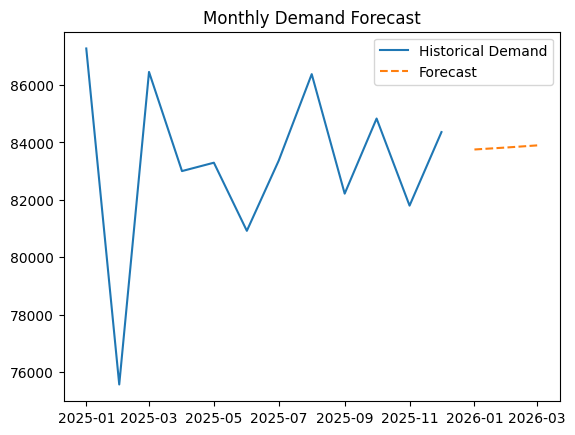

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly_demand, label="Historical Demand")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Monthly Demand Forecast")
plt.show()


In [29]:
df["final_reorder_priority"] = np.where(
    (df["stockout_probability"] > 0.7) &
    (forecast.mean() > monthly_demand["avg_daily_demand"].mean()),
    "HIGH PRIORITY",
    "NORMAL"
)

df[["sku_id", "final_reorder_priority"]].head()


,sku_id,final_reorder_priority
0,SKU_00001,HIGH PRIORITY
1,SKU_00001,HIGH PRIORITY
2,SKU_00001,NORMAL
3,SKU_00001,NORMAL
4,SKU_00001,HIGH PRIORITY
